In [59]:
############################
# 1) Install Dependencies #
############################
!pip install --upgrade torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu118
!pip install --upgrade transformers datasets evaluate librosa seaborn
!pip install bitsandbytes
!pip install pydub
!pip install praat-parselmouth



Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu118


In [60]:

############################
# 2) Import Libraries     #
############################
import os
#os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:true"
import requests
import shutil
from zipfile import ZipFile
import torch
import librosa
import datasets
import evaluate
import pandas as pd
import scipy.signal
import torch.nn as nn
import parselmouth
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from parselmouth.praat import call
from tqdm import tqdm
from datasets import load_from_disk, Dataset, DatasetDict, concatenate_datasets
from transformers import (
    Wav2Vec2ForSequenceClassification,
    Wav2Vec2Processor,
    TrainingArguments,
    Trainer,
    get_scheduler
)

from torch.nn.utils.rnn import pad_sequence
from bitsandbytes.optim import Adam8bit
from sklearn.metrics import classification_report, confusion_matrix
from pydub import AudioSegment
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
############################
# 3) Check GPU & Versions #
############################
print("Torch version:", torch.__version__)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("GPU available?", torch.cuda.is_available())
print("Using device:", device)
!nvidia-smi


Torch version: 2.6.0+cu118
GPU available? False
Using device: cpu
/bin/bash: line 1: nvidia-smi: command not found


## Data acquisition

In [61]:
urls = [
    "https://ars.els-cdn.com/content/image/1-s2.0-S0885230821001340-mmc2.zip",
    "https://ars.els-cdn.com/content/image/1-s2.0-S0885230821001340-mmc3.zip",
    "https://ars.els-cdn.com/content/image/1-s2.0-S0885230821001340-mmc4.zip",
    "https://ars.els-cdn.com/content/image/1-s2.0-S0885230821001340-mmc5.zip",
    "https://ars.els-cdn.com/content/image/1-s2.0-S0885230821001340-mmc6.zip",
    "https://ars.els-cdn.com/content/image/1-s2.0-S0885230821001340-mmc7.zip",
    "https://ars.els-cdn.com/content/image/1-s2.0-S0885230821001340-mmc8.zip",
    "https://ars.els-cdn.com/content/image/1-s2.0-S0885230821001340-mmc9.zip",
    "https://ars.els-cdn.com/content/image/1-s2.0-S0885230821001340-mmc10.zip",
    "https://ars.els-cdn.com/content/image/1-s2.0-S0885230821001340-mmc11.zip"
]

# 2) SET UP FOLDERS
# Create root directories for your final data
os.makedirs("Healthy", exist_ok=True)
os.makedirs("MCI", exist_ok=True)
os.makedirs("AD", exist_ok=True)

# Create a temporary folder for extracted files
temp_folder = "tmp_extracted"
os.makedirs(temp_folder, exist_ok=True)

# 3) DOWNLOAD AND EXTRACT EACH ZIP
for i, url in enumerate(urls):
    zip_filename = f"downloaded_{i}.zip"   # A local name to store the downloaded file

    # Download the file
    print(f"Downloading from {url}...")
    response = requests.get(url)
    with open(zip_filename, "wb") as f:
        f.write(response.content)
    print(f"Saved {zip_filename}")

    # Extract all contents into the temp_folder
    print(f"Extracting {zip_filename}...")
    with ZipFile(zip_filename, 'r') as zip_ref:
        zip_ref.extractall(temp_folder)

    # Optionally delete the ZIP file after extraction to save space
    os.remove(zip_filename)

temp_folder = "tmp_extracted"  # your temporary extraction folder



# 4) MOVE FILES INTO THE RIGHT FOLDERS (WITH MP3 TO WAV CONVERSION)
for root, dirs, files in os.walk(temp_folder):
    for filename in files:
        full_path = os.path.join(root, filename)
        # Convert MP3 to WAV if needed
        if filename.endswith(".mp3"):
            wav_filename = filename.replace(".mp3", ".wav")
            wav_path = os.path.join(root, wav_filename)
            # Convert MP3 to WAV
            audio = AudioSegment.from_mp3(full_path)
            audio.export(wav_path, format="wav")
            # Remove the original MP3
            os.remove(full_path)
            # Update full_path to the new WAV file
            full_path = wav_path
            filename = wav_filename
        # Move to corresponding folder
        if filename.startswith("AD"):
            shutil.move(full_path, os.path.join("AD", filename))
        elif filename.startswith("MCI"):
            shutil.move(full_path, os.path.join("MCI", filename))
        elif filename.startswith("HC"):
            shutil.move(full_path, os.path.join("Healthy", filename))
        else:
            print(f"File '{filename}' doesn't match AD/MCI/HC. Skipping or placing it elsewhere.")
print("MP3 conversion and file moving completed.")
# 5) CLEAN UP
shutil.rmtree(temp_folder, ignore_errors=True)
print("Temporary folder removed.")


Saved downloaded_0.zip
Extracting downloaded_0.zip...
Saved downloaded_1.zip
Extracting downloaded_1.zip...
Saved downloaded_2.zip
Extracting downloaded_2.zip...
Saved downloaded_3.zip
Extracting downloaded_3.zip...
Saved downloaded_4.zip
Extracting downloaded_4.zip...
Saved downloaded_5.zip
Extracting downloaded_5.zip...
Saved downloaded_6.zip
Extracting downloaded_6.zip...
Saved downloaded_7.zip
Extracting downloaded_7.zip...
Saved downloaded_8.zip
Extracting downloaded_8.zip...
Saved downloaded_9.zip
Extracting downloaded_9.zip...
MP3 conversion and file moving completed.
Temporary folder removed.


In [62]:
# model definition
from transformers.modeling_outputs import SequenceClassifierOutput

class Wav2Vec2ProsodicClassifier(nn.Module):
    def __init__(self, base_model, num_labels, prosodic_dim=3):
        super().__init__()
        self.wav2vec2 = base_model  # Wav2Vec2ForSequenceClassification base model
        self.fc_prosody = nn.Linear(prosodic_dim, 16)  # Project prosodic features
        # Dynamically get the hidden size from the base model configuration
        hidden_size = self.wav2vec2.config.hidden_size
        self.fc_combined = nn.Linear(hidden_size + 16, num_labels)  # Combine Wav2Vec2 + prosody

    def forward(self, input_values, prosodic_features, attention_mask=None, labels=None, **kwargs):
      outputs = self.wav2vec2(
          input_values,
          attention_mask=attention_mask,
          output_hidden_states=True
      )
      wav_embeddings = outputs.hidden_states[-1].mean(dim=1)  # (Batch, hidden_size)
      prosodic_embeddings = self.fc_prosody(prosodic_features)  # (Batch, 16)
      combined_features = torch.cat((wav_embeddings, prosodic_embeddings), dim=-1)
      logits = self.fc_combined(combined_features)  # (Batch, num_labels)

      # Ensure logits always have a batch dimension
      if logits.dim() == 1:
          logits = logits.unsqueeze(0)

      loss = None
      if labels is not None:
          loss_fct = nn.CrossEntropyLoss()
          loss = loss_fct(logits, labels)

      return SequenceClassifierOutput(
          loss=loss,
          logits=logits,
          hidden_states=outputs.hidden_states,
          attentions=outputs.attentions
      )
    def gradient_checkpointing_enable(self):
        self.wav2vec2.gradient_checkpointing_enable()
model_name = "jonatasgrosman/wav2vec2-large-xlsr-53-spanish"
processor = Wav2Vec2Processor.from_pretrained(model_name)
base_model = Wav2Vec2ForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3
)



Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at jonatasgrosman/wav2vec2-large-xlsr-53-spanish and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [63]:
## Misc definitions
ROOT_DIR = os.getcwd()
DATASET_PATH = ROOT_DIR  # Root folder where audio files are stored
OUTPUT_PATH = os.path.join(ROOT_DIR, "ProcessedFiles")
os.makedirs(OUTPUT_PATH, exist_ok=True)
LABEL_MAP = {"Healthy": 0, "MCI": 1, "AD": 2}

classes = ["HC", "MCI", "AD"]
#Extracted features
features = [
        "duration_sec",
        "num_pauses",
        "total_pause_duration",
        "phonation_time",
        "speech_rate",
        "mean_intensity",
        "stdev_intensity",
        "ltas_mean",
        "ltas_std",
    ]
## Definitions needed for the weighted cross entropy loss function
#Sample weights calculations to compensate for imbalancedd dataset
num_samples_per_class = {
    0: 197,  # Healthy (HC)
    1: 90,   # MCI
    2: 74    # AD
}
# Original class counts
num_samples_per_class = {0: 197, 1: 90, 2: 74}
# Compute original class weights
total_samples = sum(num_samples_per_class.values())
num_classes = len(num_samples_per_class)
class_weights = {cls: total_samples / (num_classes * count) for cls, count in num_samples_per_class.items()}
#  Manually increase MCI weight
class_weights[1] *= 2  # Double MCI weight
#  Normalize class weights (to prevent excessive imbalance)
max_weight = max(class_weights.values())
class_weights = {cls: weight / max_weight for cls, weight in class_weights.items()}
# Convert to PyTorch tensor
device = "cuda" if torch.cuda.is_available() else "cpu"
weights_tensor = torch.tensor([class_weights[0], class_weights[1], class_weights[2]], dtype=torch.float).to(device)
# Use in CrossEntropyLoss
criterion = torch.nn.CrossEntropyLoss(weight=weights_tensor)



In [64]:
## Functions definitions

def load_audio(file_path, target_sr=16000):
    audio, sr = librosa.load(file_path, sr=target_sr)
    return np.array(audio, dtype=np.float32), sr  # Ensure float32 output

def preprocess_function(example):
    """Processes Wav2Vec2 inputs and extracts prosodic features."""
    audio = example["audio"]
    # Wav2Vec2 processing
    inputs = processor(audio["array"], sampling_rate=audio["sampling_rate"], return_tensors="pt")
    # Extract prosodic features (without pitch)
    prosodic_features = extract_prosodic_features(example["audio"]["path"])
    # Convert prosodic features to tensor
    inputs["prosodic_features"] = torch.tensor(prosodic_features, dtype=torch.float32)
    inputs["label"] = example["label"]
    return inputs

def chunk_audio(example, max_length=16000*60):  # 60 seconds max
    audio = example["audio"]
    if len(audio) > max_length:
        example["audio"] = audio[:max_length]
    return preprocess_function(example)

# Function to compute audio duration
def compute_audio_length(file_path):
    y, sr = librosa.load(file_path, sr=None)  # Load audio
    return len(y) / sr  # Compute duration in seconds

# Extract class labels from file names
def extract_class(file_path):
    filename = file_path.split("/")[-1]  # Extract filename
    if filename.startswith("HC"):
        return "HC"  # Healthy
    elif filename.startswith("MCI"):
        return "MCI"  # Mild Cognitive Impairment
    elif filename.startswith("AD"):
        return "AD"  # Alzheimer's
    return "Unknown"


def extract_prosodic_features(audio_path):
    sound = parselmouth.Sound(audio_path)
    duration_sec = sound.duration

    # ------------------------------------------------------
    # 1) Phonation Time, Pauses, Voice Breaks
    # ------------------------------------------------------
    # Compute intensity (Praat method)
    intensity = sound.to_intensity()
    # **1) Dynamic Silence Threshold**
    # Use median intensity of voiced regions instead of a fixed 20 dB threshold
    mean_intensity = call(intensity, "Get mean", 0, 0)
    min_silence_db = mean_intensity - 15  # Adaptive threshold (-15 dB from avg.)
    # **2) Pause Detection Logic**
    min_pause_duration = 0.15  # Ignore pauses shorter than 150 ms
    time_step = 0.01  # Analysis step size (10 ms)
    silence_intervals = []
    is_silent = False
    start_silence = None

    # Iterate through intensity frames to detect pauses
    for t in np.arange(0, duration_sec, time_step):
        current_db = intensity.get_value(time=t) or 0.0

        if current_db < min_silence_db:
            if not is_silent:
                is_silent = True
                start_silence = t  # Pause starts
        else:
            if is_silent:
                end_silence = t  # Pause ends
                pause_duration = end_silence - start_silence

                if pause_duration >= min_pause_duration:
                    silence_intervals.append((start_silence, end_silence))

                is_silent = False

    # **If the file ends in silence**
    if is_silent and (duration_sec - start_silence) >= min_pause_duration:
        silence_intervals.append((start_silence, duration_sec))

    # **3) Compute Final Pause Features**
    num_pauses = len(silence_intervals)  # Number of pauses
    total_pause_duration = np.sum([end - start for start, end in silence_intervals])  # Total pause time
    phonation_time = duration_sec - total_pause_duration  # Phonated (spoken) time

    # ------------------------------------------------------
    # 2) Speech Rate
    # ------------------------------------------------------
    known_syllable_count = 126
    speech_rate = known_syllable_count / phonation_time if phonation_time > 0 else 0.0

    # ------------------------------------------------------
    # 3) Speech Energy & Intensity
    # ------------------------------------------------------
    mean_intensity = call(intensity, "Get mean", 0, 0)
    stdev_intensity = call(intensity, "Get standard deviation", 0, 0)

    # Approximate LTAS:
    spectrum = sound.to_spectrum()
    n_bands = 100
    freq_step = 5000 / n_bands
    band_energies = []
    for b in range(n_bands):
        low_freq = b * freq_step
        hi_freq = (b + 1) * freq_step
        band_energy = call(spectrum, "Get band energy", low_freq, hi_freq)
        band_energies.append(band_energy)
    ltas_mean = np.mean(band_energies)
    ltas_std = np.std(band_energies)

    # Collect features into a list (or tuple) in a consistent order:
    feature_values = [
        duration_sec,
        num_pauses,
        total_pause_duration,
        phonation_time,
        speech_rate,
        mean_intensity,
        stdev_intensity,
        ltas_mean,
        ltas_std,
    ]

    # Convert to a NumPy array (float32 for compactness/speed)
    return np.array(feature_values, dtype=np.float32)


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    report = classification_report(labels, predictions, target_names=["Healthy", "MCI", "AD"], output_dict=True)

    print("Classification Report:\n", classification_report(labels, predictions, target_names=["Healthy", "MCI", "AD"]))

    return {
        "accuracy": report["accuracy"],
        "f1_macro": report["macro avg"]["f1-score"],
        "f1_healthy": report["Healthy"]["f1-score"],
        "f1_mci": report["MCI"]["f1-score"],
        "f1_ad": report["AD"]["f1-score"],
    }

def data_collator_fn(features):
    waveforms = [torch.tensor(f["audio"]["array"]) for f in features]
    prosodic_features = torch.stack([
        torch.tensor(f["prosodic_features"], dtype=torch.float) for f in features
    ])  # Now each prosodic_features is converted to a tensor
    labels = torch.tensor([f["label"] for f in features])

    input_values = pad_sequence(waveforms, batch_first=True, padding_value=0)

    inputs = processor(
        input_values.numpy(),
        sampling_rate=16000,
        padding=True,
        return_tensors="pt"
    )

    inputs["labels"] = labels
    inputs["prosodic_features"] = prosodic_features  # Add prosodic features
    return inputs


In [65]:

audio_files = []
labels = []

for category in LABEL_MAP.keys():
    category_path = os.path.join(DATASET_PATH, category)
    if not os.path.exists(category_path):
        continue
    for file in os.listdir(category_path):
        if file.endswith(".wav"):
            audio_files.append(os.path.join(category_path, file))
            labels.append(LABEL_MAP[category])

data_df = pd.DataFrame({"file_path": audio_files, "label": labels})



## Analysis of audio duration and class dependency

In [66]:

data_df["duration"] = data_df["file_path"].apply(compute_audio_length)
data_df["class"] = data_df["file_path"].apply(extract_class)
# Extract prosodic features
prosodic_features = data_df["file_path"].apply(extract_prosodic_features)



In [67]:
# Convert the extracted feature arrays into separate columns
prosodic_df = pd.DataFrame(prosodic_features.tolist(), columns=features)
# Merge the extracted features with the main DataFrame
data_df = pd.concat([data_df, prosodic_df], axis=1)
# Drop duplicate columns (keep only one occurrence of each feature)
data_df = data_df.loc[:, ~data_df.columns.duplicated()]
data_df.head()

,file_path,label,duration,class,duration_sec,num_pauses,total_pause_duration,phonation_time,speech_rate,mean_intensity,stdev_intensity,ltas_mean,ltas_std
0,/content/Healthy/HC-M-86-12.wav,0,38.742494,HC,38.742493,0.0,0.00,38.742493,3.252243,50.129845,5.237276,0.000029,0.000111
1,/content/Healthy/HC-W-64-273.wav,0,38.066667,HC,38.066666,6.0,2.38,35.686668,3.530730,69.811852,8.711191,0.005057,0.017188
2,/content/Healthy/HC-W-81-221.wav,0,93.397664,HC,93.397667,0.0,0.00,93.397667,1.349070,57.612911,6.534229,0.000599,0.001937
3,/content/Healthy/HC-W-68-208.wav,0,33.309297,HC,33.309296,11.0,3.02,30.289297,4.159885,50.136868,9.840772,0.000053,0.000182
4,/content/Healthy/HC-M-85-111.wav,0,43.270385,HC,43.270386,21.0,6.20,37.070385,3.398940,64.174263,12.033752,0.004318,0.012532


Mean Duration: 48.17 seconds
Standard Deviation: 24.93 seconds


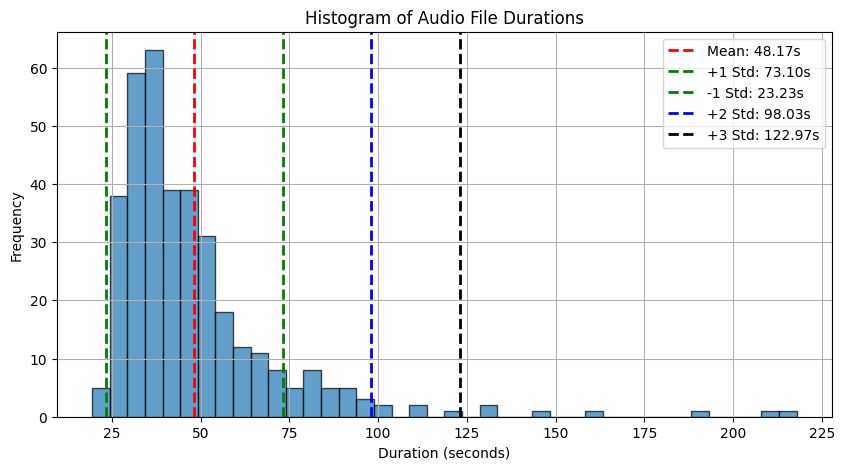

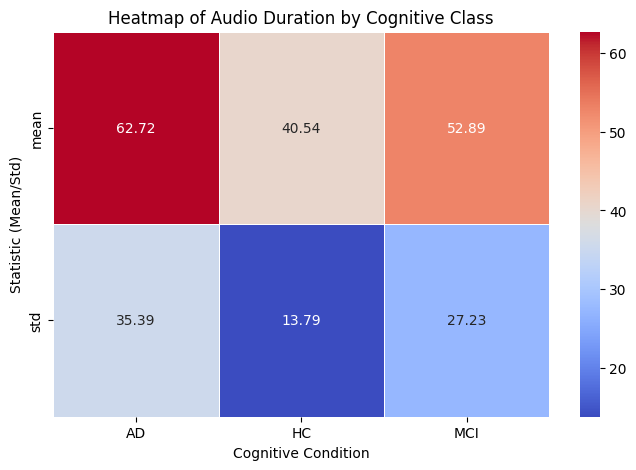

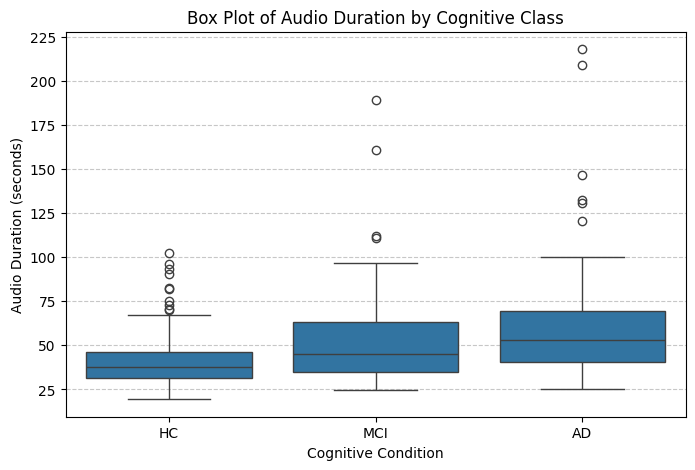

In [68]:


# Compute statistics
mean_duration = data_df["duration"].mean()
std_duration = data_df["duration"].std()
mean_values = data_df.groupby("class")[features].mean()
std_values = data_df.groupby("class")[features].std()


# Print statistics
print(f"Mean Duration: {mean_duration:.2f} seconds")
print(f"Standard Deviation: {std_duration:.2f} seconds")

# Plot a single histogram for all durations
plt.figure(figsize=(10, 5))
plt.hist(data_df["duration"], bins=40, edgecolor="black", alpha=0.7)
plt.axvline(mean_duration, color='red', linestyle='dashed', linewidth=2, label=f"Mean: {mean_duration:.2f}s")
plt.axvline(mean_duration + std_duration, color='green', linestyle='dashed', linewidth=2, label=f"+1 Std: {mean_duration + std_duration:.2f}s")
plt.axvline(mean_duration - std_duration, color='green', linestyle='dashed', linewidth=2, label=f"-1 Std: {mean_duration - std_duration:.2f}s")
plt.axvline(mean_duration + 2*std_duration, color='blue', linestyle='dashed', linewidth=2, label=f"+2 Std: {mean_duration + 2*std_duration:.2f}s")
plt.axvline(mean_duration + 3*std_duration, color='black', linestyle='dashed', linewidth=2, label=f"+3 Std: {mean_duration + 3*std_duration:.2f}s")

plt.xlabel("Duration (seconds)")
plt.ylabel("Frequency")
plt.title("Histogram of Audio File Durations")
plt.legend()
plt.grid(True)
plt.show()

# Compute mean and std deviation of duration per class
heatmap_data = data_df.groupby("class")["duration"].agg(["mean", "std"]).reset_index()
# Convert to a matrix format suitable for a heatmap
heatmap_matrix = heatmap_data.set_index("class").T

# Plot heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(heatmap_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

plt.title("Heatmap of Audio Duration by Cognitive Class")
plt.xlabel("Cognitive Condition")
plt.ylabel("Statistic (Mean/Std)")
plt.show()


## Box plot
# Create a box plot for audio duration per class
plt.figure(figsize=(8, 5))
sns.boxplot(x="class", y="duration", data=data_df)
# Formatting the plot
plt.title("Box Plot of Audio Duration by Cognitive Class")
plt.xlabel("Cognitive Condition")
plt.ylabel("Audio Duration (seconds)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


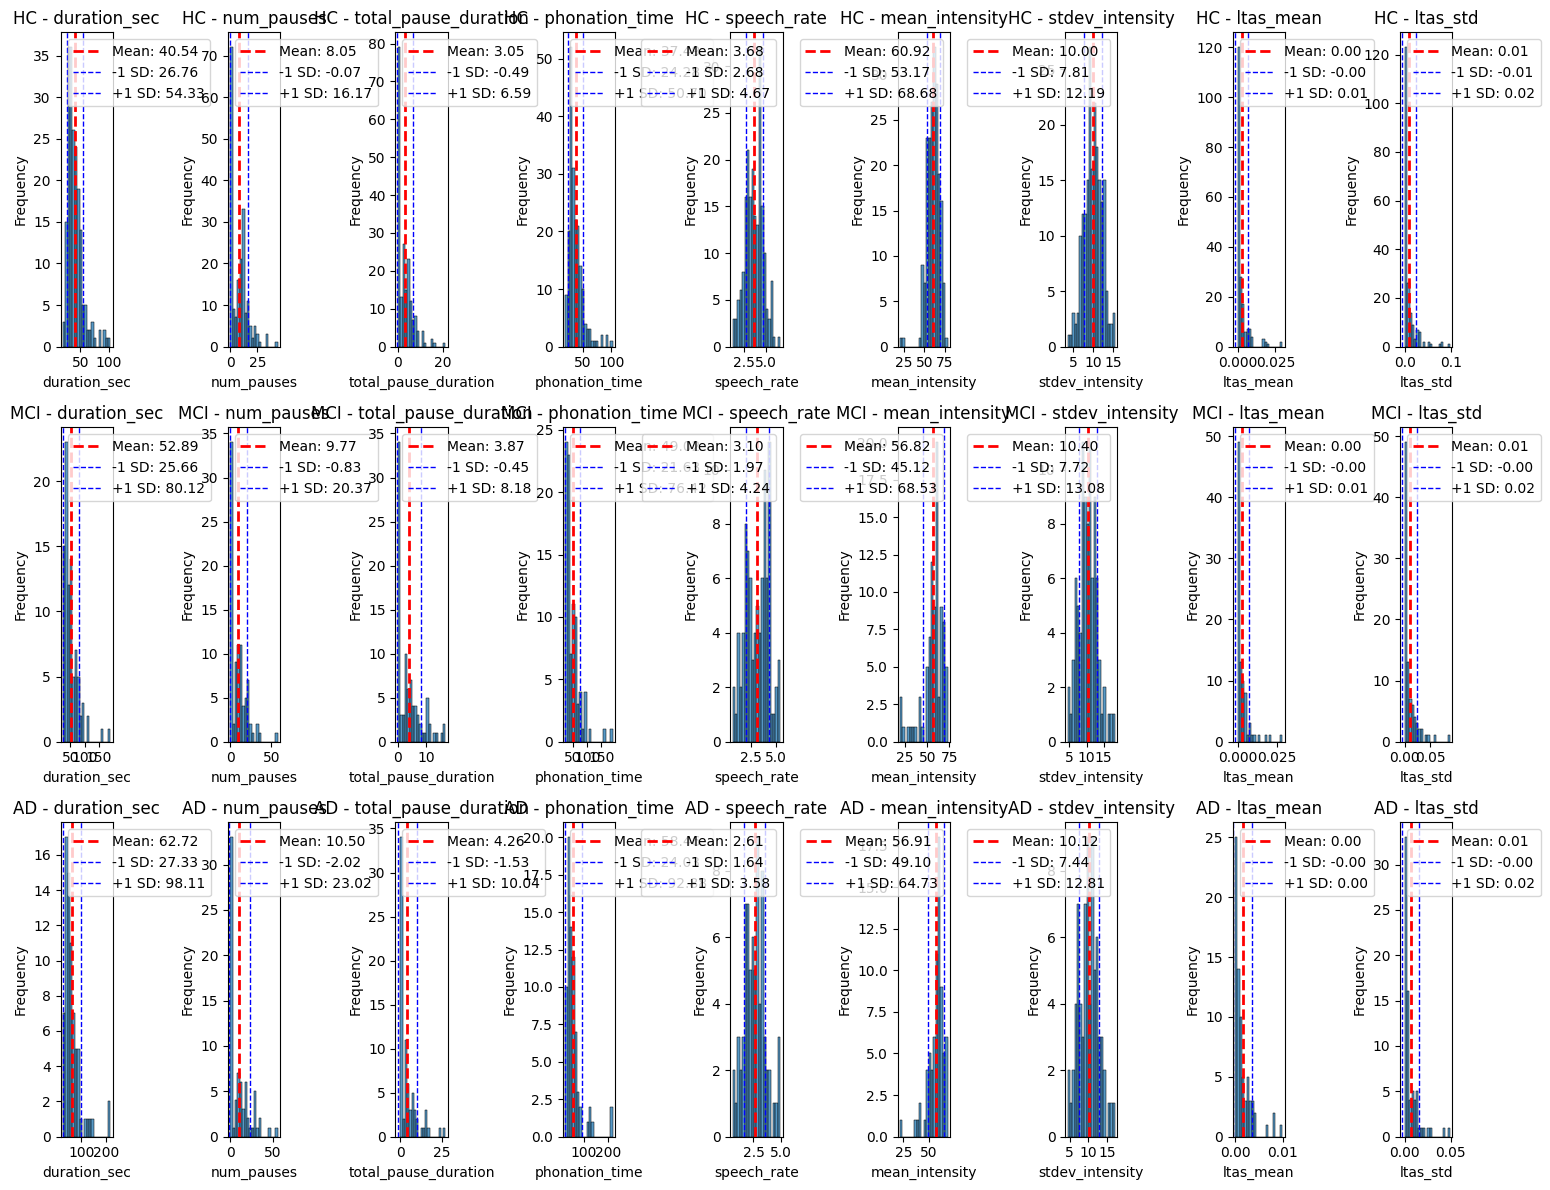


Mean and Standard Deviation per Feature per Class:


Class: HC
  Feature: duration_sec | Mean: 40.5448 | Std Dev: 13.7886
  Feature: num_pauses | Mean: 8.0508 | Std Dev: 8.1176
  Feature: total_pause_duration | Mean: 3.0521 | Std Dev: 3.5396
  Feature: phonation_time | Mean: 37.4927 | Std Dev: 13.2097
  Feature: speech_rate | Mean: 3.6768 | Std Dev: 0.9942
  Feature: mean_intensity | Mean: 60.9244 | Std Dev: 7.7529
  Feature: stdev_intensity | Mean: 9.9984 | Std Dev: 2.1897
  Feature: ltas_mean | Mean: 0.0027 | Std Dev: 0.0045
  Feature: ltas_std | Mean: 0.0087 | Std Dev: 0.0148

Class: MCI
  Feature: duration_sec | Mean: 52.8895 | Std Dev: 27.2275
  Feature: num_pauses | Mean: 9.7667 | Std Dev: 10.5990
  Feature: total_pause_duration | Mean: 3.8658 | Std Dev: 4.3150
  Feature: phonation_time | Mean: 49.0238 | Std Dev: 27.3947
  Feature: speech_rate | Mean: 3.1026 | Std Dev: 1.1343
  Feature: mean_intensity | Mean: 56.8248 | Std Dev: 11.7008
  Feature: stdev_intensity | Mean: 10.4002 

In [69]:
# Histogram of prosodic features

# Create a grid for histograms of prosodic features per class
fig, axes = plt.subplots(len(classes), len(features), figsize=(15, 12), sharex=False, sharey=False)

# Generate histograms for each feature-class combination
for i, cls in enumerate(classes):
    for j, feature in enumerate(features):
        # Plot histogram
        sns.histplot(
            data=data_df[data_df["class"] == cls],  # Filter data for the class
            x=feature,
            bins=20,
            kde=False,
            ax=axes[i, j]
        )

        # Get mean and std values
        mean_val = mean_values.loc[cls, feature]
        std_val = std_values.loc[cls, feature]
        # Add vertical lines for mean and std deviation
        axes[i, j].axvline(mean_val, color='red', linestyle='dashed', linewidth=2, label=f"Mean: {mean_val:.2f}")
        axes[i, j].axvline(mean_val - std_val, color='blue', linestyle='dashed', linewidth=1, label=f"-1 SD: {mean_val - std_val:.2f}")
        axes[i, j].axvline(mean_val + std_val, color='blue', linestyle='dashed', linewidth=1, label=f"+1 SD: {mean_val + std_val:.2f}")
        # Add text annotations for clarity
        axes[i, j].legend()
        # Set plot labels and title
        axes[i, j].set_title(f"{cls} - {feature}")
        axes[i, j].set_xlabel(feature)
        axes[i, j].set_ylabel("Frequency")
# Adjust layout for clarity
plt.tight_layout()
plt.show()

# Print mean and standard deviation values for each class and feature
print("\nMean and Standard Deviation per Feature per Class:\n")
for cls in classes:
    print(f"\nClass: {cls}")
    for feature in features:
        mean_val = mean_values.loc[cls, feature]
        std_val = std_values.loc[cls, feature]
        print(f"  Feature: {feature} | Mean: {mean_val:.4f} | Std Dev: {std_val:.4f}")



In [ ]:
# Splitting dataset
train_files, test_files, train_labels, test_labels = train_test_split(
    data_df["file_path"], data_df["label"],
    test_size=0.2, stratify=data_df["label"], random_state=42
)
train_files, val_files, train_labels, val_labels = train_test_split(
    train_files, train_labels,
    test_size=0.1, stratify=train_labels, random_state=42
)

def process_data(files, labels):
    data = []
    for file, label in tqdm(zip(files, labels), total=len(files)):
        audio, sr = load_audio(file)
        data.append({
            "audio": {
                "array": np.array(audio, dtype=np.float32),
                "sampling_rate": sr,
                "path": file  # Save file path for prosodic feature extraction if needed
            },
            "label": label
        })
    return data

train_data = process_data(train_files, train_labels)
val_data = process_data(val_files, val_labels)
test_data = process_data(test_files, test_labels)

dataset = DatasetDict({
    "train": Dataset.from_list(train_data),
    "validation": Dataset.from_list(val_data),
    "test": Dataset.from_list(test_data),
})

dataset = dataset.map(chunk_audio)
dataset.save_to_disk(OUTPUT_PATH)
print(f"Dataset saved to {OUTPUT_PATH}")



In [ ]:
############################
# 2) Load Dataset & Model  #
############################

dataset = load_from_disk(OUTPUT_PATH)
model = Wav2Vec2ProsodicClassifier(base_model, num_labels=3)
model.gradient_checkpointing_enable()
optimizer = Adam8bit(model.parameters(), lr=2e-5)

In [ ]:
############################
# 4) Training definitions  #
############################

training_args = TrainingArguments(
    output_dir="./wav2vec2_classification",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=5,
    weight_decay=0.2,
    logging_dir="./logs",
    logging_steps=10,
    report_to="none",
    fp16=True,
    remove_unused_columns=False,
    gradient_accumulation_steps=4,
    load_best_model_at_end=True,
)

class CustomTrainer(Trainer):
    def __init__(self, model, args, train_dataset, eval_dataset, data_collator, optimizers, class_weights, compute_metrics=None):
        super().__init__(
        model=model,
        args=args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        data_collator=data_collator,
        optimizers=optimizers,
        compute_metrics=compute_metrics
        )
        self.criterion = nn.CrossEntropyLoss(weight=class_weights)  # Set the weighted loss
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        prosodic_features = inputs.pop("prosodic_features")
        outputs = model(input_values=inputs["input_values"], prosodic_features=prosodic_features, labels=labels)
        logits = outputs.logits
        # Use the weighted loss function
        loss = self.criterion(logits, labels)
        return (loss, outputs) if return_outputs else loss
    def prediction_step(self, model, inputs, prediction_loss_only=False, ignore_keys=None):
        labels = inputs.pop("labels", None)  # Remove labels from inputs
        prosodic_features = inputs.pop("prosodic_features")

        with torch.no_grad():
            outputs = model(input_values=inputs["input_values"], prosodic_features=prosodic_features, labels=labels)

        loss = outputs.loss if outputs.loss is not None else None
        logits = outputs.logits

        if prediction_loss_only:
            return (loss, None, None)
        return (loss, logits, labels)

# Define the learning rate scheduler
num_training_steps = training_args.num_train_epochs * len(dataset["train"]) // training_args.gradient_accumulation_steps

lr_scheduler = get_scheduler(
    name="cosine",
    optimizer=optimizer,
    num_warmup_steps=100,  # Gradual warmup phase
    num_training_steps=num_training_steps
)

# Update Trainer initialization
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    compute_metrics=compute_metrics,
    data_collator=data_collator_fn,
    optimizers=(optimizer, lr_scheduler),
    class_weights=weights_tensor  # Pass class weights
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer.train()

In [ ]:

torch.save(model.state_dict(), "./wav2vec2_classification/model.pth")
processor.save_pretrained("./wav2vec2_classification")

print("Training complete! Model saved to ./wav2vec2_classification")


Training complete! Model saved to ./wav2vec2_classification


In [ ]:
''' !zip -r wav2vec2_classification.zip wav2vec2_classification '''

In [ ]:
''' from google.colab import files
files.download("wav2vec2_classification.zip") '''

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>